In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:

from MomentMatching.baseMomentMatch import MomentMatching, UnscentedTransform, TaylorTransform
from MomentMatching.TimeSeriesModel import TimeSeriesModel, UniformNonlinearGrowthModel
from MomentMatching.StateModels import GaussianState
from MomentMatching.ExpectationPropagation import EPNodes, TopEP

In [5]:
np.random.seed(seed=100)

In [6]:
N = 50
system = UniformNonlinearGrowthModel()
data = system.system_simulation(N)
x_true, x_noisy, y_true, y_noisy = zip(*data)

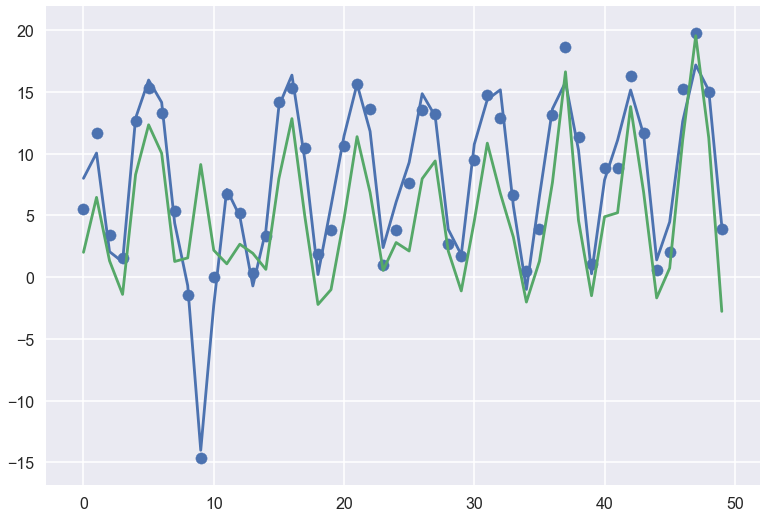

In [7]:
plt.plot(x_true)
plt.scatter(list(range(N)), x_noisy)
plt.plot(y_noisy)
plt.show()

In [8]:
transform = TaylorTransform(dimension_of_state=1)
Nodes = EPNodes(dimension_of_state=1, N=N)
EP = TopEP(system_model=system, moment_matching=transform.moment_matching_KF)


In [9]:
prior = Nodes[0].copy()
prior.marginal = system.init_dist

In [10]:
EP.forward_update(Nodes[0], prior, 0.0)

<class 'MomentMatching.ExpectationPropagation.TimeSeriesNodeForEP'>.(t=0, state_dim=1,
    marginal_init=GaussianState 
 mean=
 [ 10.52555996], 
 cov=
[[ 615.23077583]]), factor_init=(GaussianState 
 mean=
 [ 0.], 
 cov=
[[ 9999.]]), GaussianState 
 mean=
 [ 0.], 
 cov=
[[ 9999.]]), GaussianState 
 mean=
 [ 10.5254952], 
 cov=
[[ 615.22699038]])))

In [11]:
def kalman_filter(self, Nodes, observations, fargs_list):
    prior = Nodes[0].copy()
    prior.marginal = self.system_model.init_dist
        # GaussianState(mean_vec=np.array([0.1]),
        #                            cov_matrix=0.1 * np.eye(1, dtype=float))

    for node, obs, fargs in zip(Nodes, observations, fargs_list):
        pred_state = self.forward_update(node=node, prev_node=prior, fargs=fargs)
        corrected_state = self.measurement_update(pred_state, obs, fargs)
        yield corrected_state
        prior = corrected_state

        


In [19]:
ans = kalman_filter(EP, Nodes, y_noisy, range(0, N))

In [20]:
x_filtered = list(ans)
x_filt_mean = [x.marginal.mean for x in x_filtered]

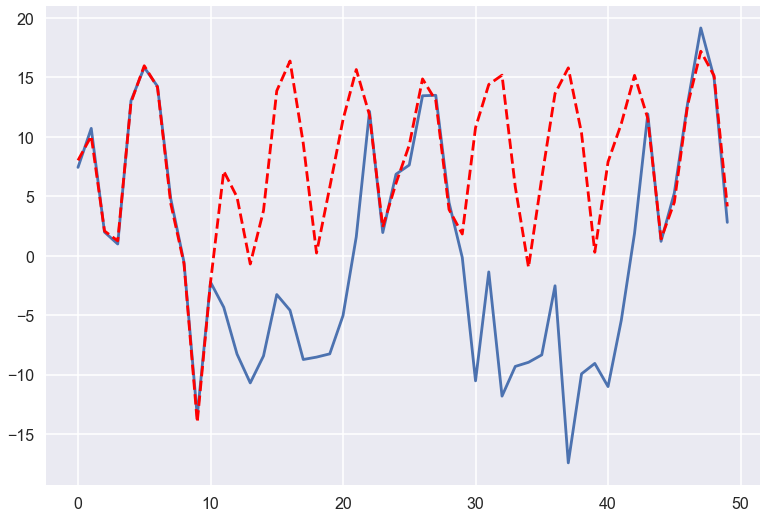

In [21]:
plt.plot(x_filt_mean)
plt.plot(x_true, 'r--', label='x_true')

In [37]:
def kalman_smoother(self, Nodes, fargs_list):
    
    reversedNodes = reversed(Nodes)
    reveresedFargs = reversed(fargs_list)
#     node, next_node = itertools.tee(reversedNodes)
#     next_node = reversedNodes[0]
    
    next(reveresedFargs)
    next_node = next(reversedNodes)
    yield next_node
    
    for node, fargs in zip(reversedNodes, reveresedFargs):
        print(fargs)
        smoothed_node = self.backward_update(node=node, next_node=next_node, fargs=fargs)
        yield smoothed_node
        next_node = smoothed_node
        

In [38]:
sms = kalman_smoother(EP, x_filtered, list(range(0, 20)))

In [40]:
next(sms)

18


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [27]:
x_filtered[-1]

<class 'MomentMatching.ExpectationPropagation.TimeSeriesNodeForEP'>.(t=49, state_dim=1,
    marginal_init=GaussianState 
 mean=
 [ 2.78816477], 
 cov=
[[ 1.78110128]]), factor_init=(GaussianState 
 mean=
 [-4.67953604], 
 cov=
[[ 11.8287101]]), GaussianState 
 mean=
 [ 0.], 
 cov=
[[ 9999.]]), GaussianState 
 mean=
 [ 4.1110734], 
 cov=
[[ 2.09639064]])))